# Otimizadores do Gradiente Descendente

Este notebook utiliza a rede inspirada na LeNet para classificar dígitos da base MNIST utilizando-se seis otimizadores diferentes

- Batch gradiente descendente
- Estocástico gradiente descendente
- Mini-batch gradiente descendente

Dificuldades que os métodos otimizadores procuram adotar:

- Ajuste da taxa de aprendizagem LR (learning rate) é difícil
- Ajuste automático da taxa de aprendizagem reduzindo-a em função de estatística durante cada época
- Normalmente o mesmo LR é utilizado em cada derivada parcial. É possível ter LR individuais
  para cada atributo, ajustando-o às estatísticas associado ao atributo
- Evitar ficar preso num mínimo local subótimo

 - **Momentum**: o LR é calculado por uma fração do gradiente anterior e o atual. Funciona como uma média móvel
   dos gradientes calculados
 - **Nesterov Accelerated Gradient (NAG)**: Variação do Momentum, onde a fração é calculada entre o gradiente anterior
   e o novo gradiente, porém calculado não no ponto atual, mas no ponto da função já corrigida pelo gradiente
 - **Adagrad**: o LR é alterado para cada dimensão de atributo. O LR de cada atributo é dividido pela raiz quadrada
   da soma dos quadrados das últimas derivadas parciais de cada época. 
   Assim, uma das vantagens do Adagrad é o fato de ser desnecessário
   ajustar o LR e lidar melhor quando as estatísticas das derivadas parciais forem bastante diferente entre as dimensões.
 - **Adadelta**: é uma variação do Adagrad, onde a soma dos quadrados seja aplicada apenas em uma janela dos gradientes
   passados e não de toda a época.
 - **RMSprop**: é um método similar a Adadelta. A curiosidade é que ele foi proposto num curso e não em artigo científico.
 - **Adam (Adaptative Moment Estimation)**: estende o Adadelta e RMSprop incorporando também não apenas o quadrado dos
   gradientes passados, também é calculado a média dos gradientes passados.
   

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time,sys,os
import numpy as np
import argparse

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format("channels_first")

from keras.datasets import mnist

print('Keras ', keras.__version__)
print('Numpy ', np.__version__)

Using TensorFlow backend.


Keras  2.0.3
Numpy  1.12.1


## MNIST database

In [2]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Pequena amostra (para testar o código)

In [3]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    X_train = X_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    X_test = X_test[:n_samples_test]
    y_test = y_test[:n_samples_test]

## LeNet-like network

In [4]:

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Conv2D(20, (5, 5), padding="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


## Função de treinamento, default de 15 épocas

In [5]:
def train_network(optimizer, X_train, y_train, X_test, y_test, nepochs=15, ploss=2.5):
    print("[INFO] creating model...")
    model = LeNet.build(width=28, height=28, depth=1, classes=10)

    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, patience=10)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nepochs)
    plot.grid(True)

    print("[INFO] training...")
    try:
        histo2 = model.fit(X_train, y_train, batch_size=128, epochs=nepochs, 
                           verbose=0, validation_split=0.33, callbacks=[my_big_callback])
    except KeyboardInterrupt:
        pass

    print("[INFO] evaluating...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))
    

## SGD with Momentum


[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 90.60%


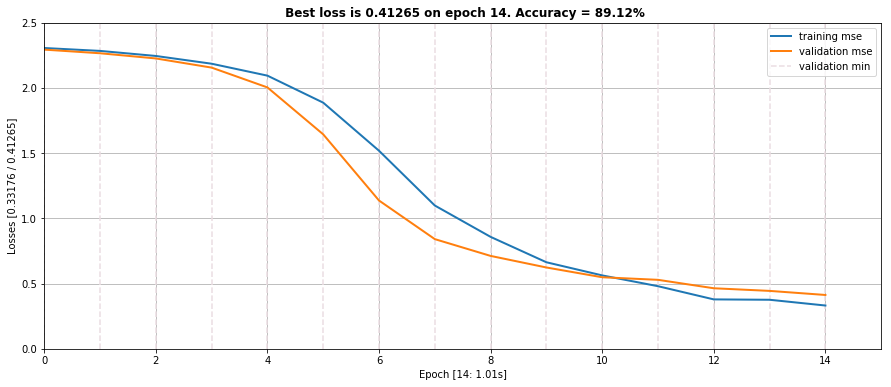

In [6]:
opt = SGD(lr=0.01, momentum=0.9)
train_network(opt, X_train, y_train, X_test, y_test)

## SGD with Nesterov momentum

[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 88.80%


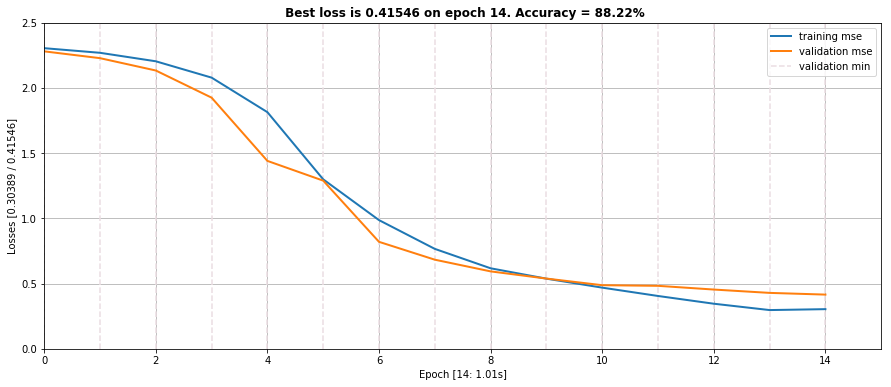

In [7]:
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
train_network(opt, X_train, y_train, X_test, y_test)

## SGD with learning rate decay

[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 93.00%


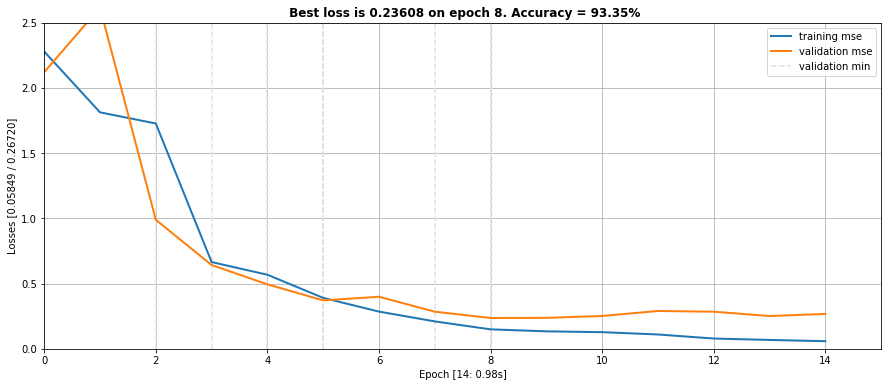

In [8]:
opt = SGD(lr=0.1, momentum=0.9, decay=0.01)
train_network(opt, X_train, y_train, X_test, y_test)

## RMSprop

[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 94.40%


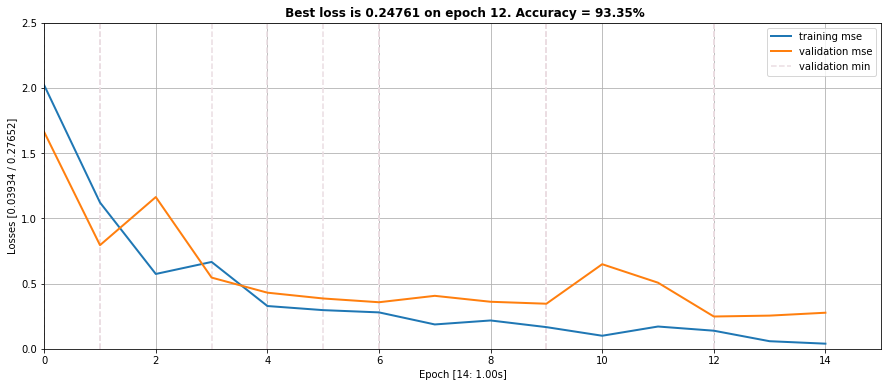

In [9]:
opt = RMSprop(lr=0.001)
train_network(opt, X_train, y_train, X_test, y_test)

## Adadelta

[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 89.00%


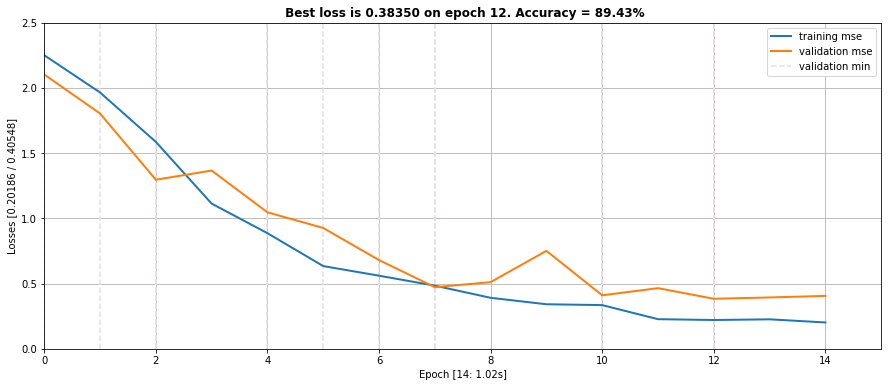

In [10]:
opt = 'adadelta'
train_network(opt, X_train, y_train, X_test, y_test)

## Adam

[INFO] evaluating...
500/500 [==============================] - 0s     
[INFO] accuracy: 93.00%


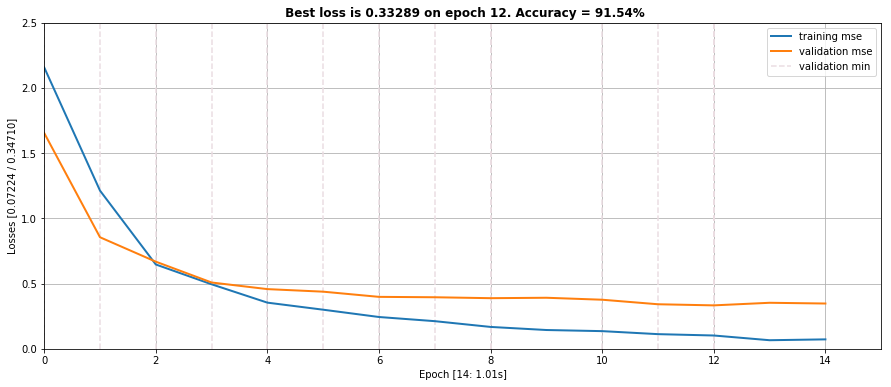

In [11]:
opt = 'adam'
train_network(opt, X_train, y_train, X_test, y_test)

## Aprendizados

